# **Uploading Data and Pre-Processing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Memuat Data
import pandas as pd

dataset = pd.read_csv("/content/drive/MyDrive/Deep Learning/Data/sentiment/capres/Capres2014-1.1.csv", usecols=["Isi_Tweet"])

In [ ]:
# EXPLORE the data
## Menampilkan lima data terakhir
dataset.tail()

,Isi_Tweet
1880,Jangan kabur dari tanggung jawab dengan kemasa...
1881,@echo_hadiwibowo mana berani pmrntah..m G da y...
1882,@IndonesiaCapres ANAK MEDAN DUKUNG CAPRES JK D...
1883,"RT @idoidonajib: Jelek! ""@fallenokta: Apa komp..."
1884,"Langsung deh ngadu ke capres Hatta Rajasa, bia..."


In [ ]:
# MODEL the data
## Pra Pengolahan - Cleaning
import numpy as np
import re

def clean_text(tweet):
    
    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    
    return tweet

dataset["Isi_Tweet"] = dataset['Isi_Tweet'].map(lambda x: clean_text(x))
dataset = dataset[dataset['Isi_Tweet'].apply(lambda x: len(x.split()) >=1)]

print(dataset.shape)

(1885, 1)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Pra Pengolahan - Representasi Data
from transformers import AutoTokenizer, TFAutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
bert_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2", trainable=False)

def tokenisasi(teks):
    encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128, 
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask
    return tokenID

def bert(data):
    emb = []
    for teks in data:
        #print(teks)
        token, mask = tokenisasi(str(teks))
        emb.append(bert_model([token, mask])[1].numpy().tolist()[0])
    
    return emb

### BERT Embedding
bert_emb = np.array(bert(dataset.to_numpy()))

print(bert_emb.shape)

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(1885, 768)


# **Pre-Plotting Coherences**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
actual_coherences=[]
max_coherences=[]
min_coherences=[]
mean_coherences=[]
med_coherences=[]

# **1. Parameter Menurut Analisis Performa EFCM dengan BERT sebagai Representasi Teks pada Pendeteksian Topik**

svd=5

m =1.1

n_topics = [2,3,4,10]

initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)

cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)

## n_topics=2 (model-1)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 2
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['yg', 'dan', 'jadi', 'capres', 'hatta', 'rt', 'jd', 'presiden', 'menjadi', 'jokowi'], ['rt', 'prabowo', 'jadi', 'capres', 'presiden', 'jokowi', 'dahlan', '2014', 'cawapres', 'indonesia']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24832308248040225


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.27501854046233115
The simulation 2
Coherence value :  0.27501854046233115
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.23793469657027533
The number of topics is 6
The simulation 1
Coherence value :  0.2521515508266116
The simulation 2
Coherence value :  0.25839577504093686
The number of topics is 7
The simulation 1
Coherence value :  0.25351423577420296
The simulation 2
Coherence value :  0.2536599823043527
The number of topics is 8
The simulat

Text(0, 0.5, 'Coherence')

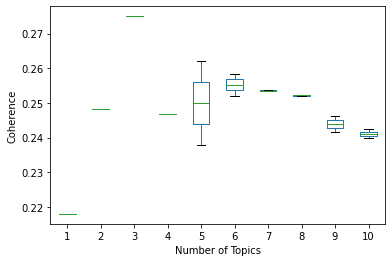

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.27501854046233115
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24843411775673924
Nilai Median Coherence= 0.24832308248040225


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253514,0.251932,0.241638,0.242374
1,0.217996,0.248323,0.275019,0.246874,0.237935,0.258396,0.253660,0.252383,0.246317,0.239791


In [ ]:
top_words

[['wonogiri',
  'vihara',
  'forum',
  'guruh',
  'rt',
  'petani',
  'capres',
  'jokowi',
  'islam',
  'dahlan'],
 ['jadi', 'kalo', 'jd', 'yg', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['2014',
  'prabowo',
  'indonesia',
  'dahlan',
  'jadi',
  'iskan',
  'mahfud',
  'presiden',
  'adalah',
  'rt'],
 ['rt',
  'jd',
  'jokowi',
  'presiden',
  'jadi',
  'ya',
  'arb',
  'emoh',
  'ahok',
  'capres'],
 ['yg',
  'dan',
  'akan',
  'saya',
  'ada',
  'prabowo',
  'bisa',
  'jadi',
  'capres',
  'di'],
 ['hatta',
  'menjadi',
  'radjasa',
  'membuka',
  'pencapresan',
  'evaluasi',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '09'],
 ['bungkus',
  'gimana',
  'bung',
  'rt',
  'cawapres',
  'jokowi',
  'capres',
  'dukung',
  'mantabbb',
  'konsultan'],
 ['jadi',
  'rt',
  'prabowo',
  'acak',
  'presiden',
  'jokowi',
  'dukung',
  'capres',
  'nya',
  'apa'],
 ['capres',
  'deklarasi',
  'jd',
  'rt',
  'jk',
  'yg',
  'hanura',
  'tdk',
  'wiranto',
  'followradiopepatah'],
 ['prabo

## n_topics=3 (model-2)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 3
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['jadi', 'jd', 'yg', 'rt', 'jokowi', 'presiden', 'capres', 'arb', 'mau', 'di'], ['rt', 'prabowo', 'jadi', 'capres', 'jokowi', 'presiden', 'dukung', 'cawapres', 'dahlan', 'arb'], ['menjadi', 'hatta', 'dan', 'sebagai', 'mantan', 'tidak', 'tokoh', 'jusuf', 'wakil', 'kalla']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.27501854046233115


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.27501854046233115
The simulation 2
Coherence value :  0.27501854046233115
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.23793469657027533
The number of topics is 6
The simulation 1
Coherence value :  0.2521515508266116
The simulation 2
Coherence value :  0.25215155082661167
The number of topics is 7
The simulation 1
Coherence value :  0.25351423577420296
The simulation 2
Coherence value :  0.25351423577420296
The number of topics is 8
The simula

Text(0, 0.5, 'Coherence')

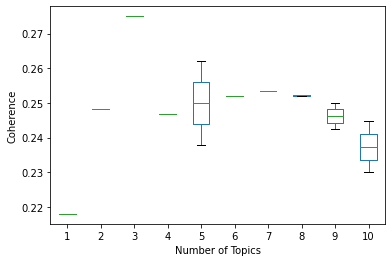

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.27501854046233115
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24796991314027145
Nilai Median Coherence= 0.24921702467663973


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253514,0.251932,0.250111,0.230003
1,0.217996,0.248323,0.275019,0.246874,0.237935,0.252152,0.253514,0.252383,0.242375,0.244737


In [ ]:
top_words

[['2014',
  'prabowo',
  'indonesia',
  'jadi',
  'mahfud',
  'iskan',
  'dahlan',
  'akan',
  'presiden',
  'rt'],
 ['capres',
  'jd',
  'rt',
  'jk',
  'deklarasi',
  'hanura',
  'yg',
  'wiranto',
  'followradiopepatah',
  'dahlan'],
 ['jadi', 'jd', 'yg', 'kalo', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['prabowo',
  'saya',
  'presiden',
  'dan',
  'harus',
  'oleh',
  'pilih',
  'adalah',
  '2014',
  'dahlan'],
 ['hatta',
  'menjadi',
  'evaluasi',
  'membuka',
  'radjasa',
  'pencapresan',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '09'],
 ['vihara',
  'wonogiri',
  'forum',
  'petani',
  'guruh',
  'capres',
  'rt',
  'jokowi',
  'islam',
  'pdip'],
 ['jadi',
  'rt',
  'prabowo',
  'acak',
  'presiden',
  'jokowi',
  'dukung',
  'nya',
  'capres',
  'apa'],
 ['rt',
  'bungkus',
  'bung',
  'gimana',
  'cawapres',
  'prabowo',
  'capres',
  'underdog',
  'jokowi',
  'charta'],
 ['rt',
  'jokowi',
  'jd',
  'presiden',
  'ya',
  'jadi',
  'emoh',
  'ahok',
  'capres',
  'aja']

## n_topics=4 (model-3)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 4
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['jadi', 'yg', 'jd', 'ya', 'rt', 'presiden', 'arb', 'aja', 'jokowi', 'mau'], ['menjadi', 'hatta', 'dan', 'sebagai', 'mantan', 'tidak', 'tokoh', 'umumnya', 'jusuf', 'kemungkinan'], ['rt', 'prabowo', 'capres', 'jokowi', 'presiden', 'cawapres', 'bung', 'gimana', 'jadi', 'acak'], ['rt', 'jadi', 'capres', 'jokowi', 'presiden', 'dahlan', 'prabowo', 'di', 'jd', 'wiranto']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24687365373773942


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.27501854046233115
The simulation 2
Coherence value :  0.27501854046233115
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.2621687633118459
The number of topics is 6
The simulation 1
Coherence value :  0.25215155082661167
The simulation 2
Coherence value :  0.25215155082661167
The number of topics is 7
The simulation 1
Coherence value :  0.25351423577420296
The simulation 2
Coherence value :  0.25351423577420296
The number of topics is 8
The simula

Text(0, 0.5, 'Coherence')

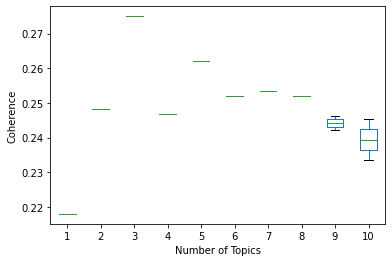

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.27501854046233115
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24916533472470945
Nilai Median Coherence= 0.2501275401152227


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253514,0.251932,0.246317,0.245346
1,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253514,0.251932,0.242152,0.233536


In [ ]:
top_words

[['bungkus',
  'gimana',
  'bung',
  'rt',
  'cawapres',
  'underdog',
  'prabowo',
  'charta',
  'politika',
  'mampu'],
 ['capres',
  'jd',
  'deklarasi',
  'rt',
  'jk',
  'hanura',
  'tdk',
  'wiranto',
  'followradiopepatah',
  'yg'],
 ['jadi', 'jd', 'yg', 'kalo', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['yg',
  'dan',
  'saya',
  'akan',
  'prabowo',
  'ada',
  'jadi',
  'capres',
  'no',
  'bisa'],
 ['jadi',
  'rt',
  'prabowo',
  'acak',
  'presiden',
  'jokowi',
  'capres',
  'dukung',
  'nya',
  'arb'],
 ['prabowo',
  'jadi',
  'harus',
  'saya',
  'itu',
  'rt',
  'dahlan',
  'dan',
  'presiden',
  'capres'],
 ['rt',
  'jd',
  'jokowi',
  'presiden',
  'jadi',
  'ya',
  'arb',
  'emoh',
  'capres',
  'aja'],
 ['hatta',
  'menjadi',
  'pencapresan',
  'radjasa',
  'evaluasi',
  'membuka',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '09'],
 ['2014',
  'prabowo',
  'indonesia',
  'jadi',
  'iskan',
  'dahlan',
  'presiden',
  'mahfud',
  'untuk',
  'rt'],
 ['wonogiri',
  'v

## n_topics=10 (model-4)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 10
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['2014', 'prabowo', 'indonesia', 'presiden', 'adalah', 'dahlan', 'jadi', 'rt', 'mahfud', 'iskan'], ['capres', 'deklarasi', 'jk', 'rt', 'hanura', 'tdk', 'jd', 'followradiopepatah', 'wiranto', 'yg'], ['rt', 'prabowo', 'cawapres', 'bung', 'bungkus', 'capres', 'gimana', 'underdog', 'politika', 'charta'], ['yg', 'dan', 'saya', 'akan', 'ada', 'prabowo', 'bisa', 'jk', 'capres', 'indonesia'], ['jd', 'rt', 'jokowi', 'presiden', 'ya', 'jadi', 'emoh', 'aja', 'capres', 'arb'], ['islam', 'wonogiri', 'vihara', 'forum', 'capres', 'petani', 'jokowi', 'dukung', 'dahlan', 'galang'], ['acak', 'jadi', 'rt', 'guruh', 'kalo', 'apa', 'prabowo', 'dukung', 'jokowi', 'di'], ['jadi', 'kalo', 'jd', 'yg', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'], ['jadi', 'rt', 'prabowo', 'presiden', 'jokowi', 'capres', 'arb', 'koruptor', 'ahok', 'dahlan'], ['hatta', 'menjadi', 'pencapresan', 'radjasa', 'evaluasi', 'membuka', 'umumnya', 'kemungkinan', '2013pan', '42']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24237391818403484


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.27501854046233115
The simulation 2
Coherence value :  0.27501854046233115
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773942
The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.26216876331184596
The number of topics is 6
The simulation 1
Coherence value :  0.25215155082661167
The simulation 2
Coherence value :  0.25839577504093686
The number of topics is 7
The simulation 1
Coherence value :  0.25365998230435277
The simulation 2
Coherence value :  0.2536599823043527
The number of topics is 8
The simula

Text(0, 0.5, 'Coherence')

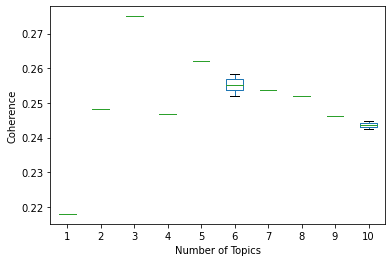

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.27501854046233115
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.25011185585075474
Nilai Median Coherence= 0.2501275401152227


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.25366,0.251932,0.246317,0.242374
1,0.217996,0.248323,0.275019,0.246874,0.262169,0.258396,0.25366,0.251932,0.246317,0.244737


In [ ]:
top_words

[['capres',
  'jd',
  'rt',
  'jk',
  'deklarasi',
  'hanura',
  'yg',
  'wiranto',
  'followradiopepatah',
  'dahlan'],
 ['yg', 'dan', 'saya', 'ada', 'jadi', 'prabowo', 'akan', 'capres', 'jk', 'di'],
 ['rt',
  'bungkus',
  'bung',
  'gimana',
  'cawapres',
  'prabowo',
  'capres',
  'underdog',
  'jokowi',
  'charta'],
 ['rt',
  'jokowi',
  'jd',
  'presiden',
  'ya',
  'jadi',
  'emoh',
  'ahok',
  'capres',
  'aja'],
 ['jadi',
  'rt',
  'prabowo',
  'acak',
  'presiden',
  'jokowi',
  'dukung',
  'nya',
  'capres',
  'apa'],
 ['2014',
  'prabowo',
  'indonesia',
  'jadi',
  'mahfud',
  'iskan',
  'dahlan',
  'akan',
  'presiden',
  'rt'],
 ['jadi', 'jd', 'yg', 'kalo', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['vihara',
  'wonogiri',
  'forum',
  'petani',
  'guruh',
  'capres',
  'rt',
  'jokowi',
  'islam',
  'pdip'],
 ['hatta',
  'menjadi',
  'evaluasi',
  'membuka',
  'radjasa',
  'pencapresan',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '09'],
 ['prabowo',
  'saya',
  'presi

# **2. Parameter Menurut The_Performance_of_BERT_as_Data_Representation_of_.pdf**

svd = TruncatedSVD(n_components = 5)

m =1.1

n_topics = [2,3,4,10]

initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)

cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)

## n_topics=2 (model-5)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 2
initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['yg', 'dan', 'jadi', 'capres', 'hatta', 'rt', 'jd', 'presiden', 'menjadi', 'jokowi'], ['rt', 'prabowo', 'jadi', 'capres', 'presiden', 'jokowi', 'dahlan', '2014', 'cawapres', 'indonesia']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24832308248040225


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.27501854046233115
The simulation 2
Coherence value :  0.27501854046233115
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.26216876331184585
The number of topics is 6
The simulation 1
Coherence value :  0.25215155082661167
The simulation 2
Coherence value :  0.25215155082661167
The number of topics is 7
The simulation 1
Coherence value :  0.2536599823043527
The simulation 2
Coherence value :  0.25365998230435277
The number of topics is 8
The simula

Text(0, 0.5, 'Coherence')

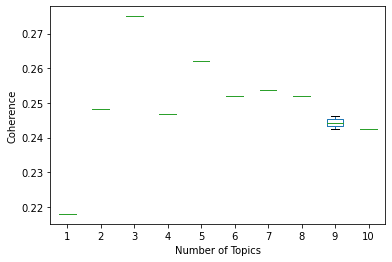

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.27501854046233115
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24948435912690198
Nilai Median Coherence= 0.2501275401152227


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.25366,0.251932,0.246317,0.242374
1,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.25366,0.251932,0.242375,0.242374


In [ ]:
top_words

[['acak',
  'jadi',
  'rt',
  'guruh',
  'kalo',
  'apa',
  'prabowo',
  'dukung',
  'jokowi',
  'di'],
 ['hatta',
  'menjadi',
  'pencapresan',
  'radjasa',
  'evaluasi',
  'membuka',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '42'],
 ['yg',
  'dan',
  'saya',
  'akan',
  'ada',
  'prabowo',
  'bisa',
  'jk',
  'capres',
  'indonesia'],
 ['jd',
  'rt',
  'jokowi',
  'presiden',
  'ya',
  'jadi',
  'emoh',
  'aja',
  'capres',
  'arb'],
 ['islam',
  'wonogiri',
  'vihara',
  'forum',
  'capres',
  'petani',
  'jokowi',
  'dukung',
  'dahlan',
  'galang'],
 ['jadi', 'kalo', 'jd', 'yg', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['2014',
  'prabowo',
  'indonesia',
  'presiden',
  'adalah',
  'dahlan',
  'jadi',
  'rt',
  'mahfud',
  'iskan'],
 ['rt',
  'prabowo',
  'cawapres',
  'bung',
  'bungkus',
  'capres',
  'gimana',
  'underdog',
  'politika',
  'charta'],
 ['jadi',
  'rt',
  'prabowo',
  'presiden',
  'jokowi',
  'capres',
  'arb',
  'koruptor',
  'ahok',
  'dahlan'],
 ['capre

## n_topics=3 (model-6)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 3
initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['rt', 'prabowo', 'jadi', 'capres', 'jokowi', 'presiden', 'dukung', 'cawapres', 'dahlan', 'arb'], ['jadi', 'jd', 'yg', 'rt', 'jokowi', 'presiden', 'capres', 'arb', 'mau', 'di'], ['menjadi', 'hatta', 'dan', 'sebagai', 'mantan', 'tidak', 'tokoh', 'jusuf', 'wakil', 'kalla']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.27501854046233115


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.27501854046233115
The simulation 2
Coherence value :  0.27501854046233115
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.26216876331184596
The number of topics is 6
The simulation 1
Coherence value :  0.25215155082661167
The simulation 2
Coherence value :  0.25215155082661167
The number of topics is 7
The simulation 1
Coherence value :  0.253514235774203
The simulation 2
Coherence value :  0.25365998230435277
The number of topics is 8
The simulat

Text(0, 0.5, 'Coherence')

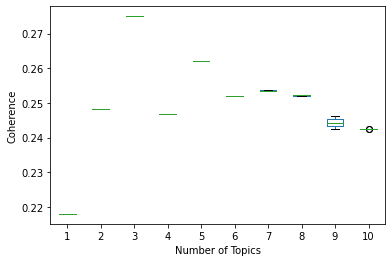

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.27501854046233115
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24949961789941294
Nilai Median Coherence= 0.2501275401152227


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253514,0.252383,0.242375,0.242374
1,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253660,0.251932,0.246317,0.242374


In [ ]:
top_words

[['capres',
  'deklarasi',
  'jk',
  'rt',
  'hanura',
  'tdk',
  'jd',
  'followradiopepatah',
  'wiranto',
  'yg'],
 ['rt',
  'prabowo',
  'cawapres',
  'bung',
  'bungkus',
  'capres',
  'gimana',
  'underdog',
  'politika',
  'charta'],
 ['jd',
  'rt',
  'jokowi',
  'presiden',
  'ya',
  'jadi',
  'emoh',
  'aja',
  'capres',
  'arb'],
 ['2014',
  'prabowo',
  'indonesia',
  'presiden',
  'adalah',
  'dahlan',
  'jadi',
  'rt',
  'mahfud',
  'iskan'],
 ['islam',
  'wonogiri',
  'vihara',
  'forum',
  'capres',
  'petani',
  'jokowi',
  'dukung',
  'dahlan',
  'galang'],
 ['jadi', 'kalo', 'jd', 'yg', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['jadi',
  'rt',
  'prabowo',
  'presiden',
  'jokowi',
  'capres',
  'arb',
  'koruptor',
  'ahok',
  'dahlan'],
 ['hatta',
  'menjadi',
  'pencapresan',
  'radjasa',
  'evaluasi',
  'membuka',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '42'],
 ['acak',
  'jadi',
  'rt',
  'guruh',
  'kalo',
  'apa',
  'prabowo',
  'dukung',
  'jokowi',
  'd

## n_topics=4 (model-7)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 4
initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['jadi', 'yg', 'jd', 'ya', 'rt', 'presiden', 'arb', 'aja', 'jokowi', 'mau'], ['rt', 'prabowo', 'capres', 'jokowi', 'presiden', 'cawapres', 'bung', 'gimana', 'jadi', 'acak'], ['rt', 'jadi', 'capres', 'jokowi', 'presiden', 'dahlan', 'prabowo', 'di', 'jd', 'wiranto'], ['menjadi', 'hatta', 'dan', 'sebagai', 'mantan', 'tidak', 'tokoh', 'umumnya', 'jusuf', 'kemungkinan']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24687365373773945


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.27501854046233115
The simulation 2
Coherence value :  0.27501854046233115
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.23793469657027533
The number of topics is 6
The simulation 1
Coherence value :  0.25215155082661167
The simulation 2
Coherence value :  0.25215155082661167
The number of topics is 7
The simulation 1
Coherence value :  0.253514235774203
The simulation 2
Coherence value :  0.25365998230435277
The number of topics is 8
The simulat

Text(0, 0.5, 'Coherence')

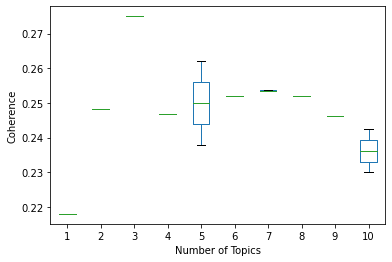

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.27501854046233115
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24784391692677618
Nilai Median Coherence= 0.24832308248040225


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253514,0.251932,0.246317,0.230003
1,0.217996,0.248323,0.275019,0.246874,0.237935,0.252152,0.253660,0.251932,0.246317,0.242374


In [ ]:
top_words

[['capres',
  'deklarasi',
  'jk',
  'rt',
  'hanura',
  'tdk',
  'jd',
  'followradiopepatah',
  'wiranto',
  'yg'],
 ['2014',
  'prabowo',
  'indonesia',
  'presiden',
  'adalah',
  'dahlan',
  'jadi',
  'rt',
  'mahfud',
  'iskan'],
 ['acak',
  'jadi',
  'rt',
  'guruh',
  'kalo',
  'apa',
  'prabowo',
  'dukung',
  'jokowi',
  'di'],
 ['jadi', 'kalo', 'jd', 'yg', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['islam',
  'wonogiri',
  'vihara',
  'forum',
  'capres',
  'petani',
  'jokowi',
  'dukung',
  'dahlan',
  'galang'],
 ['hatta',
  'menjadi',
  'pencapresan',
  'radjasa',
  'evaluasi',
  'membuka',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '42'],
 ['jadi',
  'rt',
  'prabowo',
  'presiden',
  'jokowi',
  'capres',
  'arb',
  'koruptor',
  'ahok',
  'dahlan'],
 ['rt',
  'prabowo',
  'cawapres',
  'bung',
  'bungkus',
  'capres',
  'gimana',
  'underdog',
  'politika',
  'charta'],
 ['jd',
  'rt',
  'jokowi',
  'presiden',
  'ya',
  'jadi',
  'emoh',
  'aja',
  'capres',
  'ar

## n_topics=10 (model-8)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 10
initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['islam', 'wonogiri', 'vihara', 'forum', 'capres', 'petani', 'jokowi', 'dukung', 'dahlan', 'galang'], ['jadi', 'rt', 'prabowo', 'presiden', 'jokowi', 'capres', 'arb', 'koruptor', 'ahok', 'dahlan'], ['yg', 'dan', 'saya', 'akan', 'ada', 'prabowo', 'bisa', 'jk', 'capres', 'indonesia'], ['jadi', 'kalo', 'jd', 'yg', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'], ['acak', 'jadi', 'rt', 'guruh', 'kalo', 'apa', 'prabowo', 'dukung', 'jokowi', 'di'], ['rt', 'prabowo', 'cawapres', 'bung', 'bungkus', 'capres', 'gimana', 'underdog', 'politika', 'charta'], ['2014', 'prabowo', 'indonesia', 'presiden', 'adalah', 'dahlan', 'jadi', 'rt', 'mahfud', 'iskan'], ['jd', 'rt', 'jokowi', 'presiden', 'ya', 'jadi', 'emoh', 'aja', 'capres', 'arb'], ['hatta', 'menjadi', 'pencapresan', 'radjasa', 'evaluasi', 'membuka', 'umumnya', 'kemungkinan', '2013pan', '42'], ['capres', 'deklarasi', 'jk', 'rt', 'hanura', 'tdk', 'jd', 'followradiopepatah', 'wiranto', 'yg']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24237391818403484


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.27501854046233115
The simulation 2
Coherence value :  0.27501854046233115
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.2621687633118459
The simulation 2
Coherence value :  0.2621687633118459
The number of topics is 6
The simulation 1
Coherence value :  0.25215155082661167
The simulation 2
Coherence value :  0.25215155082661167
The number of topics is 7
The simulation 1
Coherence value :  0.2536599823043527
The simulation 2
Coherence value :  0.25351423577420296
The number of topics is 8
The simulat

Text(0, 0.5, 'Coherence')

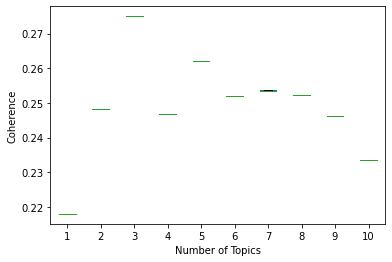

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=10, max_iter=300, tol=0.0001).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.27501854046233115
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24883551423997713
Nilai Median Coherence= 0.25023731665350696


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253660,0.252383,0.246317,0.233536
1,0.217996,0.248323,0.275019,0.246874,0.262169,0.252152,0.253514,0.252383,0.246317,0.233536


In [ ]:
top_words

[['jadi', 'jd', 'yg', 'kalo', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['wonogiri',
  'vihara',
  'forum',
  'petani',
  'guruh',
  'capres',
  'rt',
  'jokowi',
  'islam',
  'pdip'],
 ['hatta',
  'menjadi',
  'pencapresan',
  'radjasa',
  'evaluasi',
  'membuka',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '09'],
 ['bungkus',
  'gimana',
  'bung',
  'rt',
  'cawapres',
  'underdog',
  'prabowo',
  'charta',
  'politika',
  'mampu'],
 ['rt',
  'jd',
  'jokowi',
  'presiden',
  'jadi',
  'ya',
  'arb',
  'emoh',
  'capres',
  'aja'],
 ['yg',
  'dan',
  'saya',
  'akan',
  'prabowo',
  'ada',
  'jadi',
  'capres',
  'no',
  'bisa'],
 ['2014',
  'prabowo',
  'indonesia',
  'jadi',
  'iskan',
  'dahlan',
  'presiden',
  'mahfud',
  'untuk',
  'rt'],
 ['jadi',
  'rt',
  'prabowo',
  'acak',
  'presiden',
  'jokowi',
  'capres',
  'dukung',
  'nya',
  'arb'],
 ['prabowo',
  'jadi',
  'harus',
  'saya',
  'itu',
  'rt',
  'dahlan',
  'dan',
  'presiden',
  'capres'],
 ['capres',
  'jd',
  

# **3. Parameter Menurut Open Access proceedings Journal of Physics: Conference series**

svd=5

m =1.1

n_topics = [2,3,4,10]

initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)

cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)

## n_topics=2 (model-9)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 2
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['yg', 'dan', 'jadi', 'capres', 'hatta', 'rt', 'jd', 'presiden', 'menjadi', 'jokowi'], ['rt', 'prabowo', 'jadi', 'capres', 'presiden', 'jokowi', 'dahlan', '2014', 'cawapres', 'indonesia']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24832308248040225


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.2684237623892764
The simulation 2
Coherence value :  0.2684237623892764
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.24240177230584242
The simulation 2
Coherence value :  0.24240177230584242
The number of topics is 6
The simulation 1
Coherence value :  0.2553428252400072
The simulation 2
Coherence value :  0.2553428252400072
The number of topics is 7
The simulation 1
Coherence value :  0.25132449132024975
The simulation 2
Coherence value :  0.25132449132024975
The number of topics is 8
The simulati

Text(0, 0.5, 'Coherence')

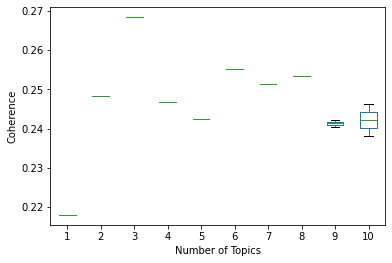

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.3
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.2684237623892764
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24676837971202653
Nilai Median Coherence= 0.24759836810907085


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.268424,0.246874,0.242402,0.255343,0.251324,0.253434,0.240420,0.238183
1,0.217996,0.248323,0.268424,0.246874,0.242402,0.255343,0.251324,0.253434,0.242228,0.246299


In [ ]:
top_words

[['prabowo',
  'indonesia',
  'yg',
  'jadi',
  'akan',
  'dan',
  'jk',
  'hanya',
  'tdk',
  'di'],
 ['rt',
  'capres',
  'wiranto',
  'dahlan',
  'jokowi',
  'deklarasi',
  'yakin',
  'jd',
  'jadi',
  'hanura'],
 ['rt',
  'prabowo',
  'cawapres',
  'capres',
  'gimana',
  'bung',
  'bungkus',
  'underdog',
  'jokowi',
  'charta'],
 ['islam',
  'wonogiri',
  'vihara',
  'capres',
  'forum',
  'petani',
  'jokowi',
  'galang',
  'rt',
  'partai2'],
 ['hatta',
  'menjadi',
  'membuka',
  'evaluasi',
  'pencapresan',
  'radjasa',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '09'],
 ['rt',
  'jokowi',
  'jd',
  'ya',
  'jadi',
  'presiden',
  'arb',
  'emoh',
  'aja',
  'capres'],
 ['jadi',
  'rt',
  'acak',
  'prabowo',
  'presiden',
  'apa',
  'jokowi',
  'guruh',
  'dukung',
  'aku'],
 ['yg', 'dan', 'mau', 'no', 'jk', 'capres', 'mikir', 'jadi', 'ndak', 'saya'],
 ['2014',
  'prabowo',
  'dahlan',
  'presiden',
  'adalah',
  'md',
  'klo',
  'mahfud',
  'indonesia',
  'iskan'],
 ['jadi

## n_topics=3 (model-10)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 3
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['jadi', 'jd', 'yg', 'rt', 'jokowi', 'presiden', 'capres', 'arb', 'mau', 'di'], ['rt', 'prabowo', 'jadi', 'capres', 'jokowi', 'presiden', 'dukung', 'cawapres', 'dahlan', 'arb'], ['menjadi', 'hatta', 'dan', 'sebagai', 'mantan', 'tidak', 'tokoh', 'jusuf', 'wakil', 'kalla']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.27501854046233115


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.2684237623892764
The simulation 2
Coherence value :  0.2684237623892764
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.24240177230584242
The simulation 2
Coherence value :  0.24240177230584242
The number of topics is 6
The simulation 1
Coherence value :  0.2553428252400071
The simulation 2
Coherence value :  0.2553428252400072
The number of topics is 7
The simulation 1
Coherence value :  0.2513244913202497
The simulation 2
Coherence value :  0.25132449132024975
The number of topics is 8
The simulatio

Text(0, 0.5, 'Coherence')

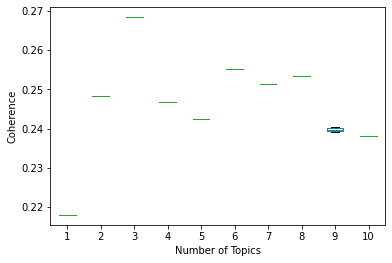

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.3
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.2684237623892764
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.2462022517356814
Nilai Median Coherence= 0.24759836810907085


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.268424,0.246874,0.242402,0.255343,0.251324,0.253434,0.240420,0.238183
1,0.217996,0.248323,0.268424,0.246874,0.242402,0.255343,0.251324,0.253434,0.239022,0.238183


In [ ]:
top_words

[['jadi', 'kalo', 'yg', 'jd', 'mau', 'sama', 'ya', 'aja', 'arb', 'om'],
 ['capres',
  'rt',
  'deklarasi',
  'hanura',
  'jd',
  'jk',
  'wiranto',
  'tdk',
  'yg',
  'followradiopepatah'],
 ['jadi',
  'acak',
  'rt',
  'prabowo',
  'guruh',
  'kalo',
  'apa',
  'di',
  'presiden',
  'jokowi'],
 ['hatta',
  'menjadi',
  'membuka',
  'pencapresan',
  'radjasa',
  'evaluasi',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '21'],
 ['rt',
  'jd',
  'jokowi',
  'presiden',
  'jadi',
  'ya',
  'emoh',
  'arb',
  'aja',
  'capres'],
 ['rt',
  'cawapres',
  'prabowo',
  'bung',
  'bungkus',
  'gimana',
  'capres',
  'underdog',
  'charta',
  'politika'],
 ['yg',
  'dan',
  'saya',
  'akan',
  'ada',
  'prabowo',
  'bisa',
  'jk',
  'capres',
  'indonesia'],
 ['vihara',
  'wonogiri',
  'islam',
  'forum',
  'petani',
  'capres',
  'jokowi',
  'dukung',
  'dahlan',
  'ppp'],
 ['jadi',
  'rt',
  'prabowo',
  'presiden',
  'jokowi',
  'capres',
  'for',
  'arb',
  'koruptor',
  'sirik'],
 ['2014',
 

## n_topics=4 (model-11)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 4
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['rt', 'prabowo', 'capres', 'jokowi', 'presiden', 'cawapres', 'bung', 'gimana', 'jadi', 'acak'], ['menjadi', 'hatta', 'dan', 'sebagai', 'mantan', 'tidak', 'tokoh', 'umumnya', 'jusuf', 'kemungkinan'], ['rt', 'jadi', 'capres', 'jokowi', 'presiden', 'dahlan', 'prabowo', 'di', 'jd', 'wiranto'], ['jadi', 'yg', 'jd', 'ya', 'rt', 'presiden', 'arb', 'aja', 'jokowi', 'mau']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24687365373773945


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.2684237623892764
The simulation 2
Coherence value :  0.2684237623892764
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773942
The number of topics is 5
The simulation 1
Coherence value :  0.24240177230584242
The simulation 2
Coherence value :  0.24240177230584242
The number of topics is 6
The simulation 1
Coherence value :  0.2553428252400071
The simulation 2
Coherence value :  0.2553428252400071
The number of topics is 7
The simulation 1
Coherence value :  0.25132449132024975
The simulation 2
Coherence value :  0.25132449132024975
The number of topics is 8
The simulati

Text(0, 0.5, 'Coherence')

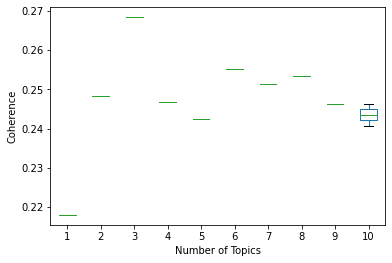

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.3
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.2684237623892764
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24739204435614962
Nilai Median Coherence= 0.24759836810907085


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.268424,0.246874,0.242402,0.255343,0.251324,0.253434,0.24626,0.240784
1,0.217996,0.248323,0.268424,0.246874,0.242402,0.255343,0.251324,0.253434,0.24626,0.246299


In [ ]:
top_words

[['prabowo',
  'indonesia',
  'yg',
  'jadi',
  'akan',
  'dan',
  'jk',
  'hanya',
  'tdk',
  'di'],
 ['2014',
  'prabowo',
  'dahlan',
  'presiden',
  'adalah',
  'md',
  'klo',
  'mahfud',
  'indonesia',
  'iskan'],
 ['jadi',
  'jd',
  'yg',
  'sama',
  'kalo',
  'ya',
  'presiden',
  'optimis',
  'di',
  'aja'],
 ['rt',
  'jokowi',
  'jd',
  'ya',
  'jadi',
  'presiden',
  'arb',
  'emoh',
  'aja',
  'capres'],
 ['jadi',
  'rt',
  'acak',
  'prabowo',
  'presiden',
  'apa',
  'jokowi',
  'guruh',
  'dukung',
  'aku'],
 ['rt',
  'capres',
  'wiranto',
  'dahlan',
  'jokowi',
  'deklarasi',
  'yakin',
  'jd',
  'jadi',
  'hanura'],
 ['yg', 'dan', 'mau', 'no', 'jk', 'capres', 'mikir', 'jadi', 'ndak', 'saya'],
 ['rt',
  'prabowo',
  'cawapres',
  'capres',
  'gimana',
  'bung',
  'bungkus',
  'underdog',
  'jokowi',
  'charta'],
 ['islam',
  'wonogiri',
  'vihara',
  'capres',
  'forum',
  'petani',
  'jokowi',
  'galang',
  'rt',
  'partai2'],
 ['hatta',
  'menjadi',
  'membuka',
  'e

## n_topics=10 (model-12)

In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Deep Learning/FCMeans")
from fcmeans import fcmeans

m =1.1
n_topics = 2
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['yg', 'dan', 'jadi', 'capres', 'hatta', 'rt', 'jd', 'presiden', 'menjadi', 'jokowi'], ['rt', 'prabowo', 'jadi', 'capres', 'presiden', 'jokowi', 'dahlan', '2014', 'cawapres', 'indonesia']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Deep Learning/Data/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.index_to_key:
                if pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)
        
        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))
actual_coherences.append(calculate_coherence(w2v_model, top_words))

0.24832308248040225


The number of topics is 1
The simulation 1
Coherence value :  0.21799575076216743
The simulation 2
Coherence value :  0.21799575076216743
The number of topics is 2
The simulation 1
Coherence value :  0.24832308248040225
The simulation 2
Coherence value :  0.24832308248040225
The number of topics is 3
The simulation 1
Coherence value :  0.2684237623892764
The simulation 2
Coherence value :  0.2684237623892764
The number of topics is 4
The simulation 1
Coherence value :  0.24687365373773945
The simulation 2
Coherence value :  0.24687365373773945
The number of topics is 5
The simulation 1
Coherence value :  0.24240177230584242
The simulation 2
Coherence value :  0.2424017723058424
The number of topics is 6
The simulation 1
Coherence value :  0.2553428252400072
The simulation 2
Coherence value :  0.2553428252400072
The number of topics is 7
The simulation 1
Coherence value :  0.25132449132024975
The simulation 2
Coherence value :  0.25132449132024975
The number of topics is 8
The simulatio

Text(0, 0.5, 'Coherence')

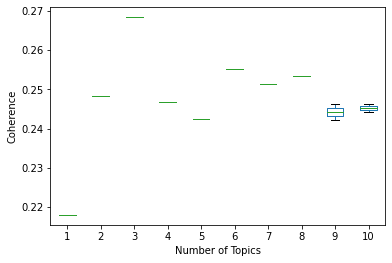

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,11,1):
    print("The number of topics is " + str(n_topics))
    
    coherence_sim = []
    for i in range(1,3):
        print("The simulation " + str(i))
               
        #topic detection
        m = 1.3
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.005, maxiter=1000, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)
        
        docs = pd.DataFrame(list(dataset["Isi_Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
        
        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
        
        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])
        
    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")

In [ ]:
print('Nilai Coherence Maksimal=',np.max(coherences))
max_coherences.append(np.max(coherences))
print('Nilai Coherence Minimal=',np.min(coherences))
min_coherences.append(np.min(coherences))
print('Nilai Rata-rata Coherence=',np.mean(coherences))
mean_coherences.append(np.mean(coherences))
print('Nilai Median Coherence=',np.median(coherences))
med_coherences.append(np.median(coherences))

Nilai Coherence Maksimal= 0.2684237623892764
Nilai Coherence Minimal= 0.21799575076216743
Nilai Rata-rata Coherence= 0.24736163243516138
Nilai Median Coherence= 0.24759836810907085


In [ ]:
coherences_new=[]
num_topics_new=[]
for i in range(len(num_topics)):
    coherences_new.append(coherences[i][0])
    coherences_new.append(coherences[i][1])
    num_topics_new.append(i+1)
    num_topics_new.append(i+1)
print('Parameter jumlah topik untuk Coherence Maksimal:',num_topics_new[coherences_new.index(np.max(coherences_new))])

Parameter jumlah topik untuk Coherence Maksimal: 3


In [ ]:
df

,1,2,3,4,5,6,7,8,9,10
0,0.217996,0.248323,0.268424,0.246874,0.242402,0.255343,0.251324,0.253434,0.246260,0.244208
1,0.217996,0.248323,0.268424,0.246874,0.242402,0.255343,0.251324,0.253434,0.242228,0.246299


In [ ]:
top_words

[['islam',
  'wonogiri',
  'vihara',
  'capres',
  'forum',
  'petani',
  'jokowi',
  'galang',
  'rt',
  'partai2'],
 ['rt',
  'capres',
  'wiranto',
  'dahlan',
  'jokowi',
  'deklarasi',
  'yakin',
  'jd',
  'jadi',
  'hanura'],
 ['2014',
  'prabowo',
  'dahlan',
  'presiden',
  'adalah',
  'md',
  'klo',
  'mahfud',
  'indonesia',
  'iskan'],
 ['jadi',
  'jd',
  'yg',
  'sama',
  'kalo',
  'ya',
  'presiden',
  'optimis',
  'di',
  'aja'],
 ['prabowo',
  'indonesia',
  'yg',
  'jadi',
  'akan',
  'dan',
  'jk',
  'hanya',
  'tdk',
  'di'],
 ['rt',
  'jokowi',
  'jd',
  'ya',
  'jadi',
  'presiden',
  'arb',
  'emoh',
  'aja',
  'capres'],
 ['rt',
  'prabowo',
  'cawapres',
  'capres',
  'gimana',
  'bung',
  'bungkus',
  'underdog',
  'jokowi',
  'charta'],
 ['hatta',
  'menjadi',
  'membuka',
  'evaluasi',
  'pencapresan',
  'radjasa',
  'umumnya',
  'kemungkinan',
  '2013pan',
  '09'],
 ['yg', 'dan', 'mau', 'no', 'jk', 'capres', 'mikir', 'jadi', 'ndak', 'saya'],
 ['jadi',
  'rt',

# **Plotting Coherences**

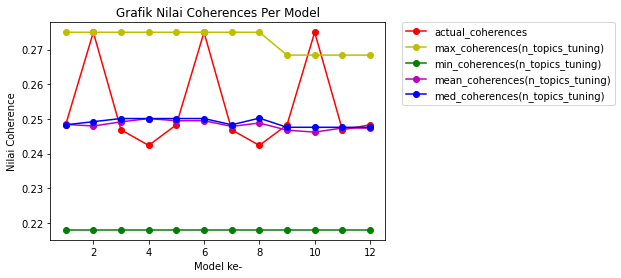

In [ ]:
x=[1,2,3,4,5,6,7,8,9,10,11,12]
y1=actual_coherences
y2=max_coherences
y3=min_coherences
y4=mean_coherences
y5=med_coherences
plt.plot(x,y1,'r-o')
plt.plot(x,y2,'y-o')
plt.plot(x,y3,'g-o')
plt.plot(x,y4,'m-o')
plt.plot(x,y5,'b-o')
plt.xlabel('Model ke-')
plt.ylabel('Nilai Coherence')
plt.legend(['actual_coherences','max_coherences(n_topics_tuning)','min_coherences(n_topics_tuning)','mean_coherences(n_topics_tuning)','med_coherences(n_topics_tuning)'],bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.title('Grafik Nilai Coherences Per Model')
plt.show()

In [ ]:
actual_coherences

[0.24832308248040225,
 0.27501854046233115,
 0.24687365373773942,
 0.24237391818403484,
 0.24832308248040225,
 0.27501854046233115,
 0.24687365373773945,
 0.24237391818403484,
 0.24832308248040225,
 0.27501854046233115,
 0.24687365373773945,
 0.24832308248040225]

In [ ]:
max_coherences

[0.27501854046233115,
 0.27501854046233115,
 0.27501854046233115,
 0.27501854046233115,
 0.27501854046233115,
 0.27501854046233115,
 0.27501854046233115,
 0.27501854046233115,
 0.2684237623892764,
 0.2684237623892764,
 0.2684237623892764,
 0.2684237623892764]

In [ ]:
min_coherences

[0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743,
 0.21799575076216743]

In [ ]:
mean_coherences

[0.24843411775673924,
 0.24796991314027145,
 0.24916533472470945,
 0.25011185585075474,
 0.24948435912690198,
 0.24949961789941294,
 0.24784391692677618,
 0.24883551423997713,
 0.24676837971202653,
 0.2462022517356814,
 0.24739204435614962,
 0.24736163243516138]

In [ ]:
med_coherences

[0.24832308248040225,
 0.24921702467663973,
 0.2501275401152227,
 0.2501275401152227,
 0.2501275401152227,
 0.2501275401152227,
 0.24832308248040225,
 0.25023731665350696,
 0.24759836810907085,
 0.24759836810907085,
 0.24759836810907085,
 0.24759836810907085]